# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

In [4]:
# coding: utf8

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [5]:
import artm

In [6]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [7]:
import numpy as np
import pandas as pd


##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [8]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lecture_batches", 
                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [10]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, dictionary=batch_vectorizer.dictionary)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [11]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [12]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=1e5, class_ids=["text"], topic_names=["bcg"], dictionary=batch_vectorizer.dictionary))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [13]:
model_artm.cache_theta = True
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [14]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e5, class_ids=["text"], topic_names=["sbj"+str(i) for i in range(T-1)], dictionary=batch_vectorizer.dictionary))

Выполните еще 15 проходов по коллекции.

In [15]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [16]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print word,
    print
    
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_authors"].last_tokens[topic_name]:
        print word,
    print

sbj0:  церковь русь средневековый император святой власть сага князь папа византийский поэзия церковный рим вера король
sbj1:  планета земля атмосфера вода солнце солнечный белый карлик газ вокруг образовываться поверхность спутник радиус метр
sbj2:  система трудность относительность тест задание преподавание отсчет системный научение компетенция адаптивный обществознание подготовка моделирование спиновый
sbj3:  культура наука рассказывать понятие кандидат исторический каков доктор культурный сознание восприятие филологический феномен владимир личность
sbj4:  право правовой римский юрист искусство суд юридический должник собственность обязательство договор владение собственник исполнение имущество
sbj5:  материал свет оптический полимер применение импульс поверхность электронный использование лазерный углеродный прибор электроника бор трехмерный
sbj6:  литература фильм текст литературный кино произведение автор герой жанр кинематограф поэт анекдот писатель читатель культовый
sbj7:  сме

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [2]:
sbj_topic_labels = [u"Христиантсво", u"Астрономия", u"Педогогика", u"Культурология", u"Правоведение", u"Физика света", u"Литература"
                   , u"История государства", u"Химия", u"Квантовая физика", u"История России", u"Семья", u"Биология", u"История цивилизаций",
                   "Физика звезд", u"компьютер и человек", u"Океанография", u"Филосовия", u"Лингвистика", u"Революция и франция", 
                   "Городские техгологии", u"Болезни и лечение", u"Социология", u"Микробиология", u"Древнегреческая мифология",
                   "Языки", u"Политика и экономика", u"Геномика", u"Физика материи"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [18]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
model_artm.cache_theta = True
phi_a = model_artm.get_phi(class_ids=["author"])
theta = model_artm.get_theta()

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [19]:
theta.iloc[:,0:100]

,http://postnauka.ru/video/56293,http://postnauka.ru/video/56295,http://postnauka.ru/video/56297,http://postnauka.ru/video/56300,http://postnauka.ru/video/56302,http://postnauka.ru/video/56304,http://postnauka.ru/video/56306,http://postnauka.ru/video/5633,http://postnauka.ru/video/56616,http://postnauka.ru/video/56618,...,http://postnauka.ru/video/59622,http://postnauka.ru/video/59627,http://postnauka.ru/video/59632,http://postnauka.ru/video/59633,http://postnauka.ru/video/59636,http://postnauka.ru/video/59638,http://postnauka.ru/video/5990,http://postnauka.ru/video/5999,http://postnauka.ru/video/60481,http://postnauka.ru/video/60527
sbj0,0.000000e+00,2.091975e-10,3.897986e-15,0.000000e+00,2.860294e-05,2.231354e-04,8.452594e-06,2.308484e-01,2.476269e-07,3.907316e-08,...,2.488945e-04,0.000000e+00,0.000000e+00,1.670282e-13,0.000000e+00,1.087391e-08,1.603403e-09,8.945954e-10,0.000000e+00,8.435628e-09
sbj1,2.663104e-07,4.713988e-07,4.524586e-04,1.750447e-02,7.030065e-10,8.054078e-05,2.831885e-07,1.034090e-08,4.760029e-12,0.000000e+00,...,3.146373e-03,7.797671e-02,3.137289e-07,3.627600e-09,2.065990e-02,3.441389e-06,0.000000e+00,0.000000e+00,3.416012e-02,1.064016e-09
sbj2,5.114917e-04,8.239496e-04,2.241855e-03,1.058490e-02,2.858652e-04,2.933764e-11,5.103632e-14,0.000000e+00,1.599888e-07,1.411186e-01,...,4.772792e-09,1.385209e-03,1.354674e-02,2.983441e-03,8.666025e-03,0.000000e+00,4.790173e-14,0.000000e+00,0.000000e+00,2.572743e-04
sbj3,1.335038e-16,3.354752e-05,7.619350e-13,8.769615e-06,2.117954e-04,9.093079e-04,8.021889e-05,3.588562e-02,1.499702e-06,2.401421e-04,...,2.637018e-03,5.774195e-03,0.000000e+00,1.610671e-06,4.384097e-05,2.588294e-02,5.282671e-03,3.967361e-02,1.663794e-06,4.437509e-03
sbj4,4.303632e-07,0.000000e+00,8.954359e-09,0.000000e+00,0.000000e+00,4.180812e-06,5.647184e-08,2.493382e-02,8.764223e-09,6.252262e-03,...,1.298845e-14,0.000000e+00,1.854680e-15,6.479216e-05,0.000000e+00,1.406504e-02,5.996265e-14,0.000000e+00,0.000000e+00,5.263623e-16
sbj5,2.828056e-02,3.810053e-02,1.928497e-03,5.113649e-03,3.758950e-07,0.000000e+00,1.628181e-06,0.000000e+00,9.515224e-10,7.102118e-07,...,7.389550e-13,4.752171e-06,3.668697e-03,2.802380e-14,0.000000e+00,2.723266e-07,0.000000e+00,0.000000e+00,6.222751e-04,1.707169e-05
sbj6,4.755772e-11,1.077825e-13,6.236576e-09,2.800909e-13,1.509449e-04,1.339854e-03,1.500013e-01,3.804683e-05,7.464255e-06,1.296770e-04,...,1.105797e-09,0.000000e+00,1.943995e-16,0.000000e+00,1.105724e-05,0.000000e+00,0.000000e+00,1.982138e-02,0.000000e+00,6.016092e-13
sbj7,1.447606e-14,6.754886e-10,1.188485e-05,6.168071e-14,2.892435e-07,8.180870e-03,2.378200e-03,5.684932e-15,0.000000e+00,9.188237e-05,...,4.459542e-03,2.188821e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.122988e-11,4.181550e-06,0.000000e+00,6.860568e-11
sbj8,3.761486e-02,2.157391e-01,1.246216e-03,0.000000e+00,1.469667e-12,0.000000e+00,5.995268e-08,0.000000e+00,9.590354e-03,8.565630e-06,...,1.499602e-05,0.000000e+00,1.446376e-03,5.664049e-11,2.225444e-06,0.000000e+00,0.000000e+00,0.000000e+00,2.719391e-09,1.043699e-08
sbj9,5.623017e-02,1.882904e-02,3.775756e-03,2.019950e-01,1.567358e-14,2.392610e-16,4.264888e-03,7.126726e-13,7.299528e-07,3.625171e-06,...,2.376097e-03,1.348560e-02,7.482107e-08,3.052385e-04,3.867445e-04,3.445969e-05,1.396057e-02,1.234732e-06,1.374103e-01,6.030795e-05


C:\Users\KIM\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


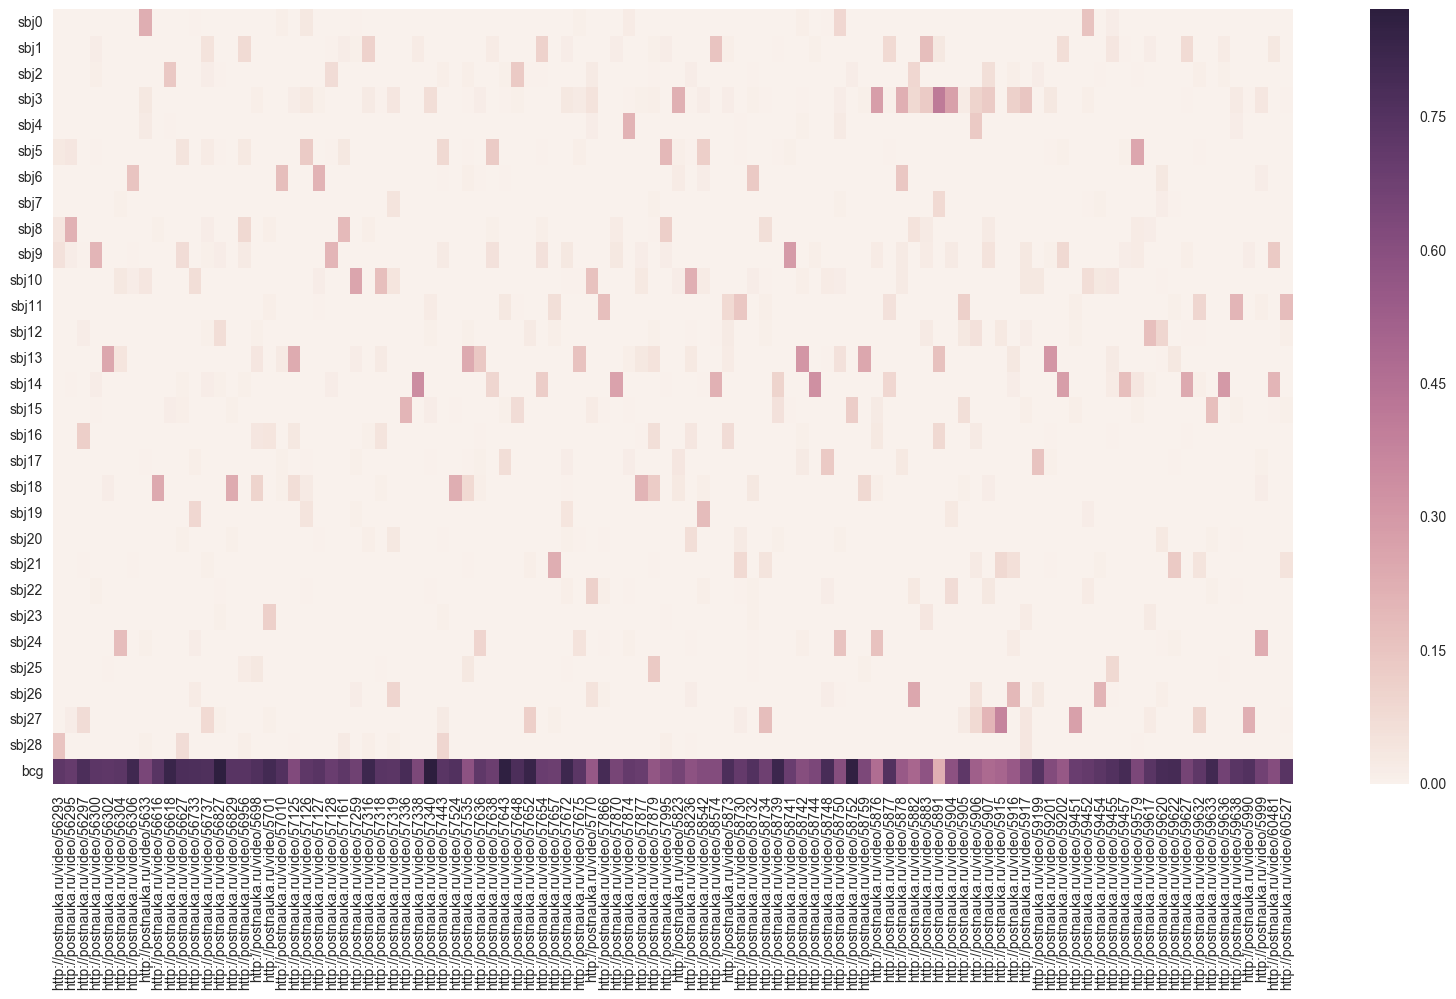

In [20]:
# Ваш код
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = seaborn.heatmap(theta.iloc[:,0:100])
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [34]:
# Ваш код
import pandas
pt =  theta.sum(axis=1)
pt = pt / sum(pt)
pt

sbj0     0.010333
sbj1     0.010865
sbj2     0.005906
sbj3     0.041352
sbj4     0.007676
sbj5     0.009931
sbj6     0.007173
sbj7     0.003850
sbj8     0.010780
sbj9     0.020969
sbj10    0.014185
sbj11    0.007344
sbj12    0.010171
sbj13    0.013725
sbj14    0.015661
sbj15    0.010314
sbj16    0.005796
sbj17    0.013691
sbj18    0.013233
sbj19    0.005871
sbj20    0.008766
sbj21    0.009659
sbj22    0.009299
sbj23    0.005917
sbj24    0.008248
sbj25    0.003987
sbj26    0.010919
sbj27    0.022148
sbj28    0.005237
bcg      0.676995
dtype: float32

In [22]:
sorted = pt.sort_values()

In [23]:
sorted[:3]

sbj7     0.003850
sbj25    0.003987
sbj28    0.005237
dtype: float32

In [24]:
sorted[-7:]

sbj13    0.013725
sbj10    0.014185
sbj14    0.015661
sbj9     0.020969
sbj27    0.022148
sbj3     0.041352
bcg      0.676995
dtype: float32

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [1]:
print sbj_topic_labels[7], sbj_topic_labels[25], sbj_topic_labels[28]
print sbj_topic_labels[13], sbj_topic_labels[10], sbj_topic_labels[14], sbj_topic_labels[9], sbj_topic_labels[27], sbj_topic_labels[3]

NameError: name 'sbj_topic_labels' is not defined

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

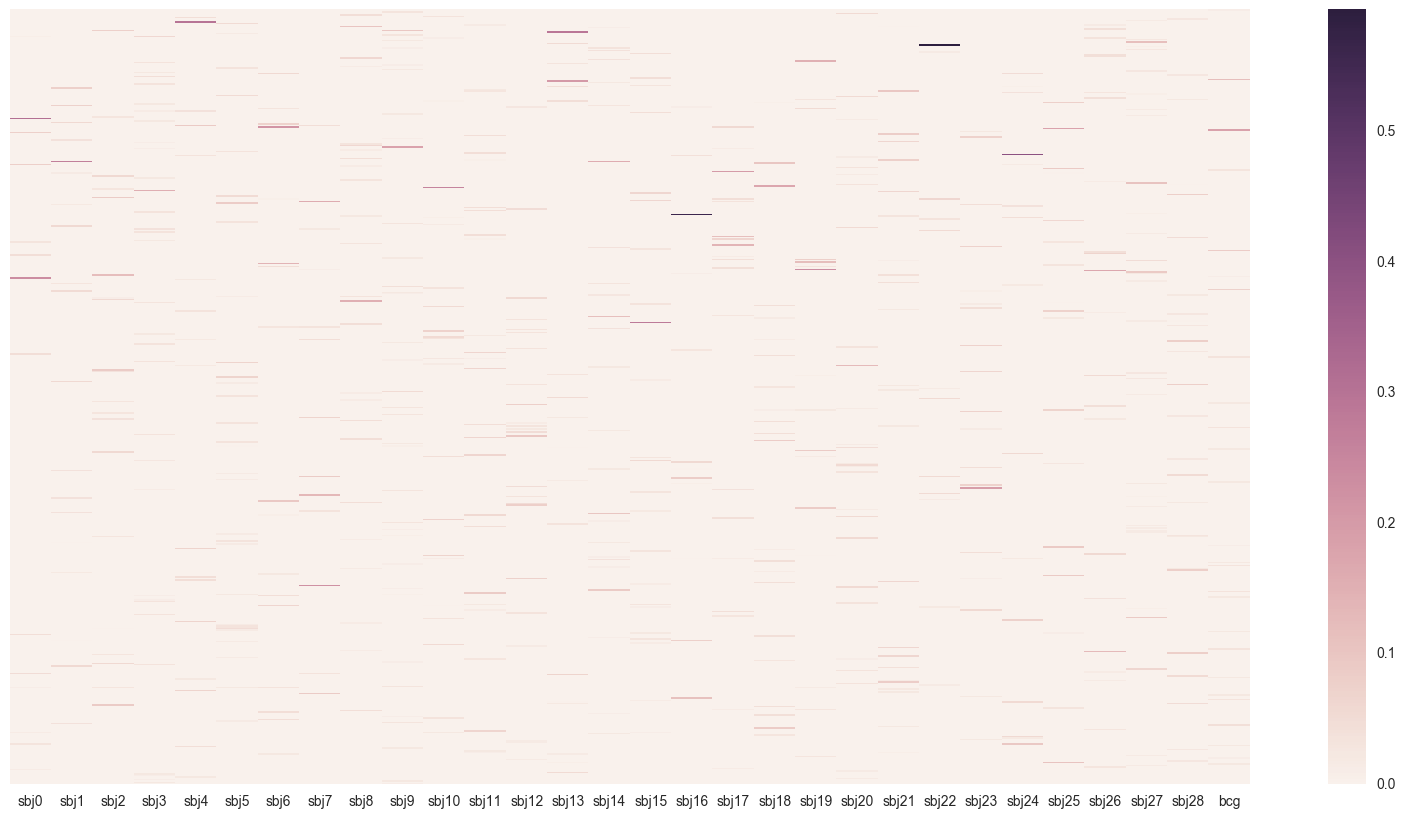

In [26]:
# Ваш код
fig = plt.figure(figsize=(20,10))
ax2 = seaborn.heatmap(phi_a, yticklabels=False)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [27]:
phi_a[phi_a[phi_a[:]> 0.01].notnull().sum(axis=1) >= 3]

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Алина_Бодрова,0.000000,0.0,0.000000,0.000000e+00,0.020776,0.000000,0.000000,0.047955,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Илья_Иткин,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.069472,0.0,0.0,0.0,0.0
Александр_Воеводский,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018789,0.000000,0.0,0.0,0.0,0.0
Ольга_Вайнштейн,0.010380,0.0,0.028409,0.000000e+00,0.000000,0.024419,0.032978,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Ольга_Тогоева,0.014255,0.0,0.000000,1.941844e-09,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [47]:
# Ваш код 
pta = phi_a.values * pt.values.T
pta /= np.sum(pta)

In [48]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

mds = MDS(dissimilarity='precomputed')
distances_cos = pairwise_distances(X=pta, metric='cosine')
MDS_transformed_cos = mds.fit_transform(distances_cos)

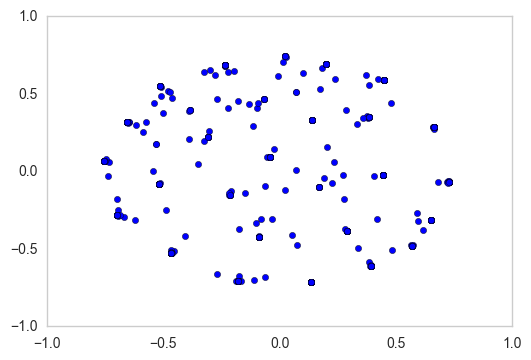

In [49]:
# Ваш код
plt.scatter(MDS_transformed_cos[:, 0], MDS_transformed_cos[:, 1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

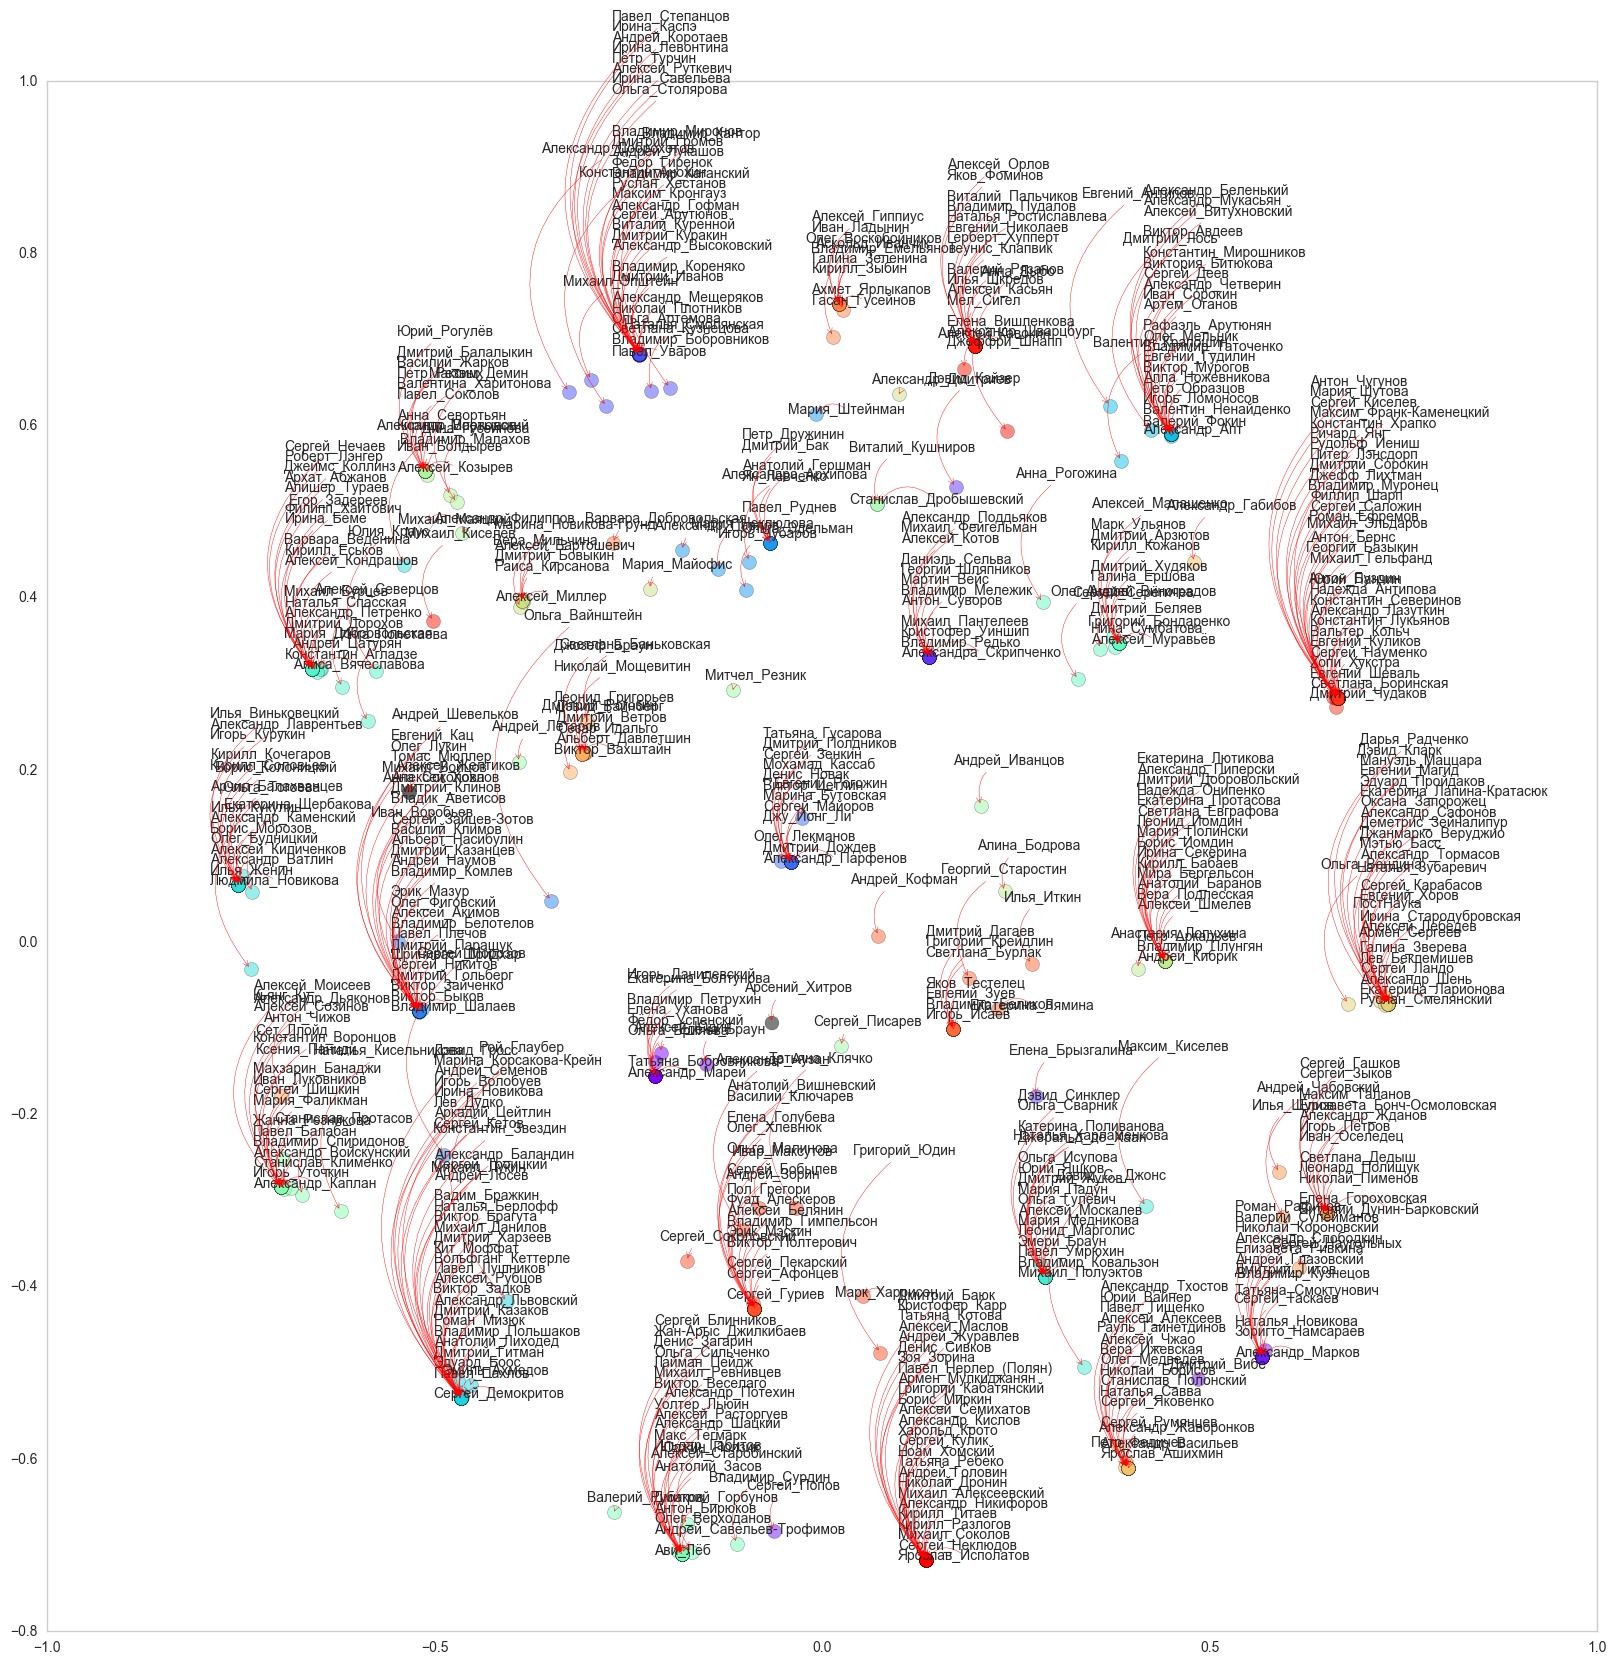

In [50]:
import matplotlib.cm as cm
import numpy as np
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
fig = plt.figure(figsize=(20, 20))
response_subset = pta.argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, T))
for y, c in zip(set(response_subset), colors):
    positions = response_subset==y
    plt.scatter(MDS_transformed_cos[positions, 0],
               MDS_transformed_cos[positions, 1],
               c=c, alpha=0.5, s=100)
    for i, (name, xy) in enumerate(zip(phi_a[positions].index, MDS_transformed_cos[positions])):
        plt.annotate(name, xy=xy, xytext=(-20, i * 7.5), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))
plt.savefig('authors.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [40]:
# Ваш код
pdt = theta.div(theta.sum(axis=1), axis=0)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [42]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [42]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [45]:
# Ваш код
for i, topic_name in enumerate(model_artm.topic_names):
    display(HTML('<h2>' + topic_labels[i] + '</h2>'))
    words = model_artm.score_tracker['top_words'].last_tokens    
    display(HTML(u'<font color="green">' + ' '.join(words[topic_name]) + '</font>'))
    indices = pdt.values[i, :].argsort()[-10:][::-1]
    display(HTML('<ul>'))
    for ref in pdt.columns[indices]:
        display(HTML('<li><a href={}>{}</li>'.format(ref, ref)))
    display(HTML('</ul>'))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 